# Unsupervised Anomaly Detection using <u>Vector Embeddings</u> of Text Security Logs
This is a continuation of the prior research. In this notebook, we are leveraging the <u>Isolation Forest</u> algorithm to perform unsupervised training of an anomaly detection model, using text <u>vector embeddings</u> as the input. As we'll see, the results are more accurate than simply clustering the data using it's vector embedding and trying to determine whether it's an anomaly merely from those groupings, but it's still not perfect.  That said, the results are around twice as accurate as the clustering exercise, but not as accurate as vectorizing known benign samples and using vector search to identify least semantic similarity. However, starting from scratch with an unsupervised model could be used to provide the data for the more accurate vector similarity search approach. It's a worthwhile approach to examine.

In [51]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
###! pip install -r .\requirements.txt --force

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

In [2]:
# We'll use the fabricated mixed proxy logs with known 950 benign log entries and 50 malicious log entries 
# Our goal is to see if we can get them accurately classified into that 950 benign + 50 malicious
# Read the log data into a dataframe, and drop the columns we don't need for this exercise, and 
# extract the return code to use in validating the eventual output
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df['return_code'] = df['Log Entry'].str.split().str[3]

df.sample(3)

,ID,Log Entry,return_code
848,849,GET http://cloudstorage.com/authenticate HTTP/...,200
409,410,"GET http://intranet.company.com/home HTTP/1.1""...",200
755,756,"GET http://www.example.com/style.css HTTP/1.1""...",200


In [3]:
# Let's confirm that we have 950 benign (rc = 200) and 50 malicious (rc != 200)
df['return_code'].value_counts()

return_code
200    950
403     18
500     11
404     11
400     10
Name: count, dtype: int64

In [4]:
# Load the embedding model so we can use it to easily populate the dataframe
from sentence_transformers import SentenceTransformer
vector_embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') # Base vector embedding model
#vector_embedder = SentenceTransformer("multi-qa-mpnet-base-cos-v1")  # Different results, longer but not better
# Use like this: embeddings = vector_embedder.encode(whatever_text)

### Model fine-tuned for Cybersecurity
# Load model directly
#from transformers import AutoTokenizer, AutoModelForMaskedLM
#tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")
#vector_embedder = AutoModelForMaskedLM.from_pretrained("jackaduma/SecBERT")

# Use a lambda function to encode the text in each row and apply it to a new column
df['embedding'] = df['Log Entry'].apply(lambda text:vector_embedder.encode(text))
df.sample(3)

c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,ID,Log Entry,return_code,embedding
806,807,"GET http://intranet.company.com/home HTTP/1.1""...",200,"[0.007171466, -0.031017033, -0.009414613, -0.0..."
335,336,"GET http://www.example.com/style.css HTTP/1.1""...",200,"[-0.03217384, 0.060404748, 0.011519817, -0.001..."
719,720,"GET http://intranet.company.com/home HTTP/1.1""...",200,"[0.0044826684, -0.029738884, -0.0055143572, -0..."


In [5]:
# Define a model object with the Isolation Forest algorithm
#model=IsolationForest(n_estimators=100,max_samples='auto',contamination=0.05,random_state=96)
#model=IsolationForest(n_estimators=100,max_samples='auto',contamination='auto',random_state=96)
model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding'].values)

# Fit the data to the model
model.fit(X)

# Display parameter values that were used
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [6]:
# Add a column to the DF for scores from the model's decision_function
df['raw_score'] = model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score'] = model.predict(X)


In [7]:
# Display the data with the columns added
df.sample(3)

,ID,Log Entry,return_code,embedding,raw_score,anomaly_score
521,522,"GET http://www.example.com/style.css HTTP/1.1""...",200,"[-0.028242653, 0.051982034, 0.01806041, -0.000...",0.038322,1
962,963,GET http://www.example.com/index.php?page=../....,400,"[-0.023413748, -0.031125512, -0.03088941, -0.0...",-0.077009,-1
124,125,"GET http://www.example.com/ HTTP/1.1"" 200 4696...",200,"[0.025887543, 0.009499743, -0.004411923, -0.02...",0.063920,1


In [8]:
# Display just the anomalies
df[df['anomaly_score']==-1].sample(3)

,ID,Log Entry,return_code,embedding,raw_score,anomaly_score
257,258,"GET http://intranet.company.com/home HTTP/1.1""...",200,"[0.0341029, -0.03927156, -0.03259958, -0.04541...",-0.001033,-1
953,954,GET http://www.example.com/search?q=<script>al...,404,"[0.025540454, 0.03765754, -0.030997962, 0.0204...",-0.056749,-1
125,126,"GET http://www.example.com/script.js HTTP/1.1""...",200,"[-0.02132573, -0.001950505, -0.005118318, -0.0...",-0.004711,-1


In [9]:
# The outliers have anomaly_score = -1 
# This output is much better than the 711/289 split we got from prior clustering exercises.
# NOTE:  Setting max_samples very high helps...the output below is very close to the known 950/50

# We could perhaps dig into the data to validate, then adjust contamination parameter to get better 
# on-going accuracy from this unsupervised algorithm. It would be worth trying with real data.
df['anomaly_score'].value_counts()

anomaly_score
 1    928
-1     72
Name: count, dtype: int64

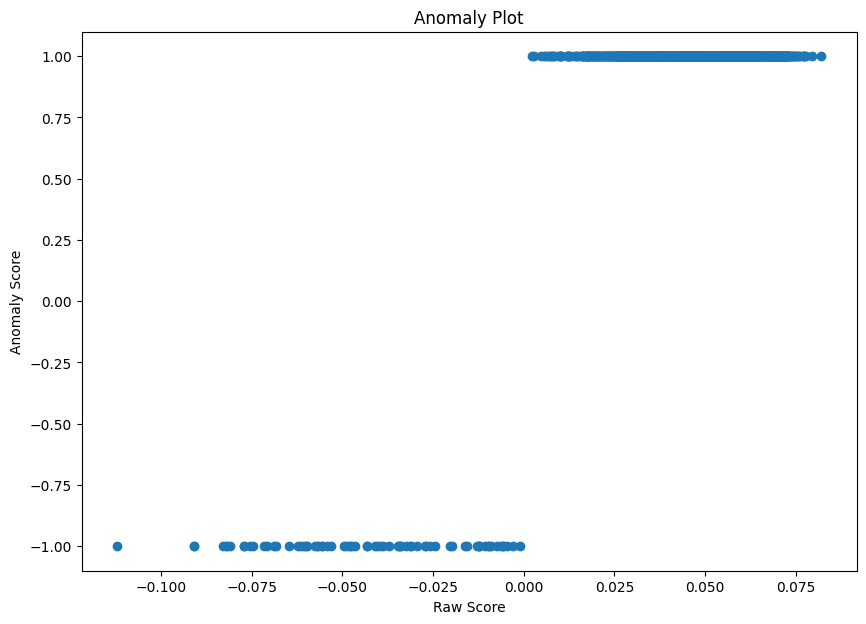

In [10]:
# If we just do a scatter plot of the anomaly_score results, it's very clear...but doesn't really tell us much.
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df.raw_score, df.anomaly_score)
plt.title('Anomaly Plot')
plt.xlabel('Raw Score')
plt.ylabel('Anomaly Score')
plt.show()

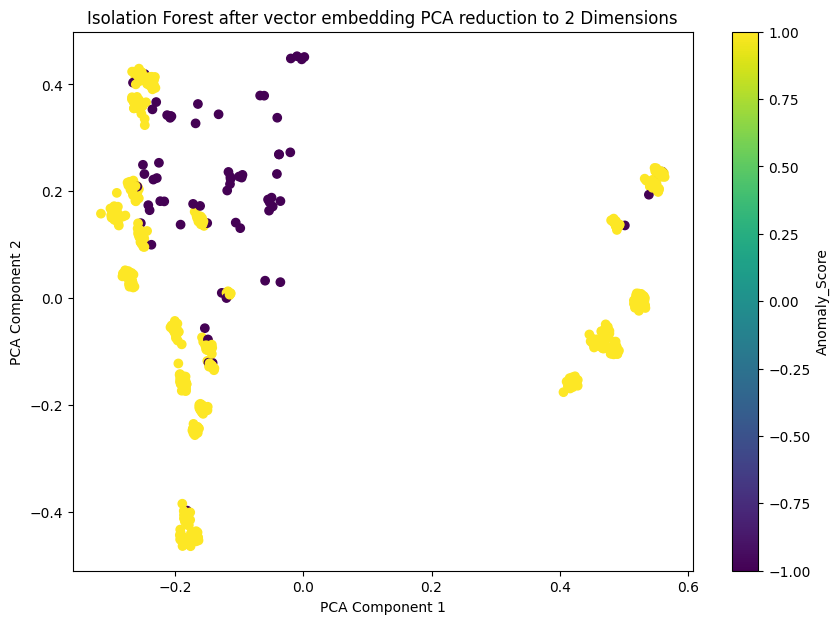

In [11]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings = df['embedding'].tolist()
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['anomaly_score'], cmap='viridis', marker='o')
plt.title('Isolation Forest after vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()

In [13]:
# Let's examine whether the 70-ish anomalies include all of the 50 known malicious log entries
print("GOOD: Count of entries flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))
print("FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score']]))
print("GOOD: Count of entries not flagged anomaly and return_code is 200: ", end='')
print(len(df[(df['anomaly_score'] == 1) & (df['return_code'] == '200')][['return_code', 'anomaly_score']]))

GOOD: Count of entries flagged anomaly and return_code not 200: 50
FALSE POSITIVE: Count of entries flagged anomaly but return_code is 200: 22
FALSE NEGATIVE: Count of entries not flagged anomaly and return_code not 200: 0
GOOD: Count of entries not flagged anomaly and return_code is 200: 928


In [14]:
# Good news...there were zero "false negatives"...all malicious entries were flagged as anomalies.

# Let's examine the "false positives"...rows flagged as anomaly but have return_code 200
pd.set_option('max_colwidth', None) # show full width of showing cols
df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score', 'Log Entry']]

# These may have been truly anomalies (unusual log entries compared to the bulk of logs), but just were 
# not actually malicious log entries

,return_code,anomaly_score,Log Entry
24,200,-1,"GET http://cloudstorage.com/files HTTP/1.1"" 200 365923 ""http://cloudstorage.com/files"" ""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36"
56,200,-1,"GET http://cloudstorage.com/authenticate HTTP/1.1"" 200 54006 ""http://cloudstorage.com/authenticate"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
75,200,-1,"GET http://cloudstorage.com/files HTTP/1.1"" 200 427776 ""http://cloudstorage.com/files"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
116,200,-1,"GET http://www.example.com/style.css HTTP/1.1"" 200 330502 ""http://www.example.com/style.css"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
125,200,-1,"GET http://www.example.com/script.js HTTP/1.1"" 200 540058 ""http://www.example.com/script.js"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
127,200,-1,"GET http://cloudstorage.com/authenticate HTTP/1.1"" 200 978580 ""http://cloudstorage.com/authenticate"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
202,200,-1,"GET http://www.example.com/style.css HTTP/1.1"" 200 171544 ""http://www.example.com/style.css"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15"
206,200,-1,"GET http://update.software.com/version.xml HTTP/1.1"" 200 330881 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
230,200,-1,"GET http://update.software.com/version.xml HTTP/1.1"" 200 805145 ""http://update.software.com/version.xml"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"
245,200,-1,"GET http://update.software.com/check HTTP/1.1"" 200 8511 ""http://update.software.com/check"" ""Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0"


Our unsupervised Isolation Forest ML model seems to have done very well with this fabricated data. All 50 malicious logs (non-200 return code) were flagged as anomalies, plus 20-ish other non-malicious log entries that may have actually been anomalies even though they were not malicious. This is definitely worth using to examine real log data.  The fact that there were no "false negatives" (no malicious logs missed) is a very desireable characteristic. The 20-ish logs flagged as anomalies that were not malicious are essentially "white noise". 